In [1]:
import pandas as pd
import numpy as np 
from functools import reduce
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

### 2.1 Import data from CSV into pandas dataframe

In [2]:
pdata = pd.read_csv("./Programming_Part1_TTI_Challenge.csv", sep='\t')

In [3]:
stats = pd.DataFrame(pdata.iloc[:,2:].describe())## gather stastics for last two columns
gm = lambda n: reduce(lambda x,y: x*y, n) ** (1.0 / len(n)) ## Function to calculate geometric mean
stats.loc[8] = [gm(pdata.X) , gm(pdata.Y)]

In [4]:
pdata.head()

,Class,PartNo,X,Y
0,AAA,X135,0.21,1.124
1,AAA,X126,0.21,1.179
2,EBHA,X195,0.32,1.191
3,EBHA,X194,0.82,1.249
4,AAA,X139,0.81,1.255


### 2.2 Print all data stastics in one table 

In [5]:
stats.rename(index={8: 'geo.mean'}) ## Last row for geometric mean 

,X,Y
count,100.000000,100.000000
mean,5.499100,3.525130
std,2.672921,1.734591
min,0.210000,1.124000
25%,3.515000,2.086250
50%,5.310000,2.974000
75%,7.810000,4.919500
max,10.020000,7.498000
geo.mean,4.495324,3.108310


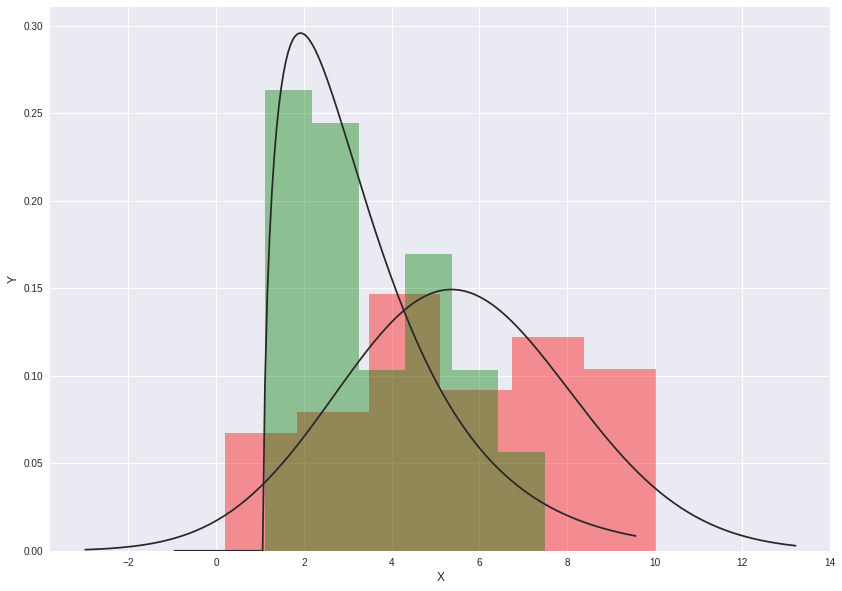

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats #libraries for plotting 
from scipy import signal


%matplotlib inline
plt.figure(figsize=(14,10)) #set size
sns.distplot((pdata.X),color="red", label="X" ,kde=False, fit=stats.gamma) #try to approximate a distribution over data with fit()
sns.distplot((pdata.Y),color="green",label="Y", kde=False, fit=stats.gamma)

plt.ylabel('Y', fontsize=12)
plt.xlabel("X", fontsize=12)
plt.show()

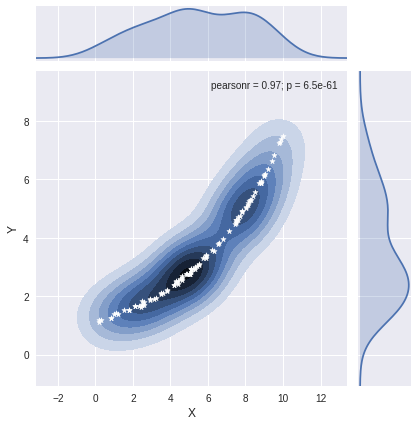

In [34]:
%matplotlib inline
plt.figure(figsize=(14,10)) #set size
g = sns.jointplot(x="X", y="Y", data=pdata, kind="kde"); ## use KDE method to get more idea about the data
g.plot_joint(plt.scatter, c="w", s=30, linewidth=.5, marker="*") ## plot a line in data with all the data points
g.ax_joint.collections[0].set_alpha(0)

plt.ylabel('Y', fontsize=12)
plt.xlabel("X", fontsize=12)
plt.show()

### From the plots we can see that the two features are highly correlated and form a clear function curve. 

### 2.3 To write out data to a table, it can be done in many ways but for this exercise I am sqlite db since it is a lightweight and minimal to setup. The connection part can be replace with any database details/jdbc connections, such as Oracle or MySQL.

### The code also demonstrate that we can convert the data into a RDBMS table and fetch it back.

In [8]:
import sqlite3
conn = sqlite3.connect("new.db")
pdata.to_sql("p1", conn, if_exists="replace")
cur = conn.cursor()
cur.execute("select * from p1 limit 5;")
results = cur.fetchall()
print(results)
conn.commit()
conn.close()

[(0, 'AAA', 'X135', 0.21, 1.124), (1, 'AAA', 'X126', 0.21, 1.179), (2, 'EBHA', 'X195', 0.32, 1.1909999999999998), (3, 'EBHA', 'X194', 0.82, 1.249), (4, 'AAA', 'X139', 0.81, 1.255)]


#### We can convert the Class feature to a categorical one. 

In [9]:
pdata.nunique() #find number of unique categories
pdata.Class.value_counts()

EBHA    41
AAA     38
EBGB    21
Name: Class, dtype: int64

In [10]:
pdata.Class = pdata["Class"].astype("category")

In [11]:
X_cat = pd.get_dummies(pdata , columns=["Class"])
X_cat.drop('Y', 1,inplace=True)

In [12]:
from sklearn.model_selection import train_test_split
X_cat.set_index("PartNo", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_cat, pdata["Y"], test_size=0.33, random_state=2111)

### 2.4  Predictive Model 
### Establish a baseline with a dummy regressor, so we know that we are doing better than predicting mean. 

In [13]:
model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)
Y_pred=model.predict(X_test)
print(mean_absolute_error(y_test,Y_pred))

1.63321076436


In [14]:
X_train.head()

,X,Class_AAA,Class_EBGB,Class_EBHA
PartNo,,,,
X170,5.03,0,0,1
X107,4.81,0,1,0
X157,3.50,1,0,0
X162,7.81,0,0,1
X112,9.51,0,1,0


In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

Y_pred=model.predict(X_test)
print("MAE", mean_absolute_error(y_test,Y_pred))
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted'))

MAE 0.412411786194
R2_score 0.924114425336


### From plots we could see that the scatterplot has a very clear function curve, this can be leveraged by using a gradient based learner. 

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=160, learning_rate=0.09,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
print("MAE", mean_absolute_error(y_test, est.predict(X_test)))
print("R2_score",r2_score(y_test,est.predict(X_test), multioutput='variance_weighted'))

MAE 0.0478280763597
R2_score 0.998826076235


In [17]:
model = XGBRegressor(n_estimators=160,seed=0, learning_rate=0.09)
model.fit(X_train, y_train)
Y_pred=model.predict(X_test)
print("MAE", mean_absolute_error(y_test,Y_pred))
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted'))

MAE 0.0510166399985
R2_score 0.998674836216


### 2.5 Gradient based methods have resulted in much better performance with near perfect R2 score and low mean absolute error. The reason that simple linear regression did not work so well here could be that the simple linear model could not generalize/model the curve function so well. Where as, since the data curve represented a differentiable function at which gradient models excel. 

### The low error means that the predictions by this model would only be off by a 0.05 of the actual values. High R2 square suggests that 99.8% of the data can be explained by the model


### Also, X is the most important feature for predicting the target value. While part number has a little contribution as well.

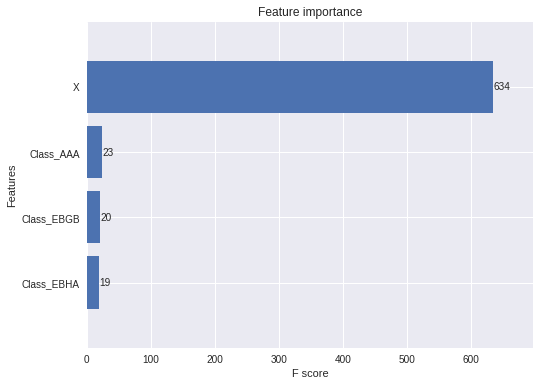

In [18]:
from xgboost import plot_importance 
fig, ax = plt.subplots(figsize=(8,6))
plot_importance(model, height=0.8, ax=ax)
plt.show()

# 3 SQL Questions 
#### Write the SQL  statements to: 
1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’) 
2. Calculate Total Revenue from Table B 
3. Display the top 10 Products from Table B which made highest profit 
4. Display total cost, total Price and Margins grouped by Parent_MFG in table A 
5. Display the highest selling product and the second highest selling product  
6. Display the Total Cost and Total Revenue based on Type from Table C and order it in a descending order 
7. Find which Quarter sold highest number of products 
8. Find which quarter made the highest sale in ‘AUTOMOTIVE’ category In the last year 
9. Find the Products in table C that haven’t sold 

In [272]:
def get_dtype(s):
    import re    
    if re.match("^\d+?\.\d+?$", s) is None:
        if s.isdigit():
            return "int"
        else:
            return "string"
    return "float"

catFeatures = []
numFeatures = []

def process_dtypes(df):
    for col,x in df.iloc[1,:].iteritems():
        t = get_dtype(str(x).strip())
        if(t == "int" or t == "float" ):
            numFeatures.append(col)
            if t == "int":
                df[col] = df[col].astype(int)
            else:
                df[col] = df[col].astype(float)
        else:
            catFeatures.append(col)
            df[col] = df[col].astype(str)
    return df    

def file_to_table(fn, cols, conn=conn): #helper function to read data from a file and return a dataframe from it.
    table = []
    tname = fn.split(".")[2].strip("/")
    f = open(fn, 'r')
    for i in f:
        table.append(i.strip())
    table = np.reshape(table, [-1,cols])
    columns = table[0,:]
    data = table[1:,:]
    temp = pd.DataFrame(data, columns=columns)
    process_dtypes(temp)
    temp.to_sql(tname, conn, if_exists="replace")
    conn.commit()
    f.close()
    
    return temp

In [273]:
s = "../MFG.txt"
conn = sqlite3.connect("new.db")


In [274]:
MFG = file_to_table('../MFG.txt',4)
products = file_to_table('../product_table.txt',5)
sales = file_to_table('../sales_table.txt',7)


#### 1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’) 
``` mysql
 select RIGHT(a.Full_MFG_Name, LENGTH(a.Full_MFG_Name) -6) as Name , b.* from MFG a, sales_table b where a.MFG_Code = b.MFG_code;
 
```

#### 2. Calculate Total Revenue from Table B 
``` mysql
 select sum(quantity * unit_price) as revenue from sales_table;
 22595.3201681077
```

#### Total Profit  
``` mysql
select sum((quantity * unit_price) - (quantity * unit_cost)) as revenue from sales_table order by revenue desc LIMIT 10;
4281.87903094292
```

#### 3. Display the top 10 Products from Table B which made highest profit

``` mysql
 select ((quantity * unit_price) - (quantity * unit_cost)) as revenue from sales_table order by revenue desc LIMIT 10;

>  revenue
544.000291824341
540.999984741211
540.999984741211
524.800281524658
331.020011901855
283.799991607666
250
186.76000213623
178.500032424927
159.999966621399
```


#### 4. Display total cost, total Price and Margins grouped by Parent_MFG in table A 



``` mysql
select a.Parent_MFG , sum(b.Unit_Cost) as Unit_Cost, sum(b.Unit_Price) as Unit_price, (sum( (b.quantity * b.unit_price) - (b.quantity * b.unit_cost) )/sum(b.quantity * b.unit_price) )*100 as profit_margin_pct
from MFG a, sales_table b 
where a.MFG_Code = b.MFG_code
group by a.Parent_MFG
order by a.Parent_MFG;


    Query #5 (Executed in 3ms)
    | parent_mfg |	unit_cost |	unit_price |	profit_margin_pct|
    ACG | Amphenol Connector Group 	970.132 	1031.99 	9.20290857973324
    AVC | AVX Corporation 	59.7 	75.85 	14.0426265605136
    KCC | KOA Corporation 	0.75 	0.87 	13.793100967702
    KCO | Kemet Corporation 	29.14 	41.515 	28.4770947263481
    TEG | TE Connectivity Group 	112.814 	224.77 	48.3635106304724
```

#### 5. 

```mysql

select 
pt.type as type,
sum((st.quantity * st.unit_price) - (st.quantity * st.unit_cost))      as total_revenue,
sum(st.unit_cost) as total_cost
from product_table pt, sales_table st
where st.product = pt.product
group by type
order by type desc;

    number_of_products 	quart
    10029 	1
    8630 	2
    6742 	3
    568 	4

```